<a href="https://colab.research.google.com/github/LoPA607/NLP/blob/main/RNN_and_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from gensim import corpora
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv("yelp_reviews_subset_2.csv")
df

,Unnamed: 0,Text,Labels
0,0,My expectations for McDonalds are t rarely hig...,0
1,1,I've tried to give this McDonalds a chance but...,0
2,2,This McDonald's is so bad it's amazing. \n\nO...,0
3,3,We had the worst possible experience at the Ea...,0
4,4,They burned my fish and they burned it bad. O...,2
...,...,...,...
495,495,This place is PHENOMENAL.\nI got my bunny here...,4
496,496,"This is a bizarre CVS, the kind you would only...",1
497,497,"I go to this CVS all the time, since I work in...",1
498,498,"Never again. Let me repeat, never again. \n\nT...",0


<ipython-input-3-5e1ba775d1ce>:14: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df['sentiment']).plot.bar(title="Sentiment distribution in df")


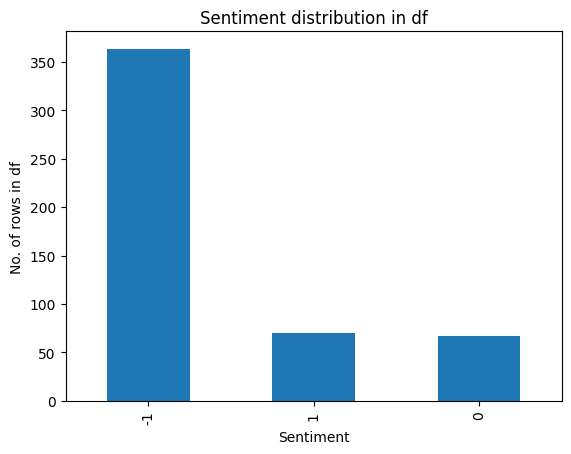

In [3]:
def map_sentiment(stars_received):
    if stars_received <= 2:
        return -1
    elif stars_received == 3:
        return 0
    else:
        return 1


# Mapping stars to sentiment into three categories
df['sentiment'] = [ map_sentiment(x) for x in df['Labels']]
# Plotting the sentiment distribution
plt.figure()
pd.value_counts(df['sentiment']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

In [4]:
# TODO: Tokenize each sentence into word tokens and store them as a list in the dataframe
# Use List Comprehension
nltk.download('punkt')
df['tokenized_text'] = [word_tokenize(x) for x in df['Text']]
print(df['tokenized_text'].head(10))

ps = PorterStemmer()
# TODO: Use the Porter Stemmer to find stem words of each word for all the words in df["tokenized_text"]
# Hint: Use List Comprehension
df['stemmed_tokens'] = [[ps.stem(word) for word in x] for x in df['tokenized_text']]
df['stemmed_tokens'].head(10)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


0    [My, expectations, for, McDonalds, are, t, rar...
1    [I, 've, tried, to, give, this, McDonalds, a, ...
2    [This, McDonald, 's, is, so, bad, it, 's, amaz...
3    [We, had, the, worst, possible, experience, at...
4    [They, burned, my, fish, and, they, burned, it...
5    [Some, how, even, though, the, food, at, this,...
6    [Mmm, ..., peppermint, mocha\n\nIn, my, quest,...
7    [If, there, was, ever, a, \, '', get, your, co...
8    [I, just, realized, they, remodeled, this, one...
9    [Great, location, !, Close, to, shops, and, th...
Name: tokenized_text, dtype: object


,stemmed_tokens
0,"[my, expect, for, mcdonald, are, t, rare, high..."
1,"[i, 've, tri, to, give, thi, mcdonald, a, chan..."
2,"[thi, mcdonald, 's, is, so, bad, it, 's, amaz,..."
3,"[we, had, the, worst, possibl, experi, at, the..."
4,"[they, burn, my, fish, and, they, burn, it, ba..."
5,"[some, how, even, though, the, food, at, thi, ..."
6,"[mmm, ..., peppermint, mocha\n\nin, my, quest,..."
7,"[if, there, wa, ever, a, \, '', get, your, cof..."
8,"[i, just, realiz, they, remodel, thi, one, rec..."
9,"[great, locat, !, close, to, shop, and, theatr..."


In [5]:
# Train Test Split Function
def split_train_test(df, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(df[["Text", "Labels", "tokenized_text", "stemmed_tokens"]],
                                                        df['sentiment'],
                                                        shuffle=shuffle_state,
                                                        test_size=test_size,
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(df)

Value counts for Train sentiments
sentiment
-1    255
 1     49
 0     46
Name: count, dtype: int64
Value counts for Test sentiments
sentiment
-1    108
 1     21
 0     21
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
   index                                               Text  Labels  \
0    139  The food is standard American fare--a bit over...       1   
1    129  I'm not much of a beer drinker, but my fiancee...       3   
2    258  ok so i've eaten here more than once but just ...       1   
3    227  Food was ok had a steak w/ shrimp side Ass mas...       1   
4     60  He was incredibly sexist/homophobic. He could ...       0   

                                      tokenized_text  \
0  [The, food, is, standard, American, fare, --, ...   
1  [I, 'm, not, much, of, a, beer, drinker, ,, bu...   
2  [ok, so, i, 've, eaten, here, more, than, once...   
3  [Food, was, ok, had, a, steak, w/, shrimp, sid...   
4  [He, was, incredi

In [6]:
# TODO: Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


In [22]:
class RecurrentNeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RecurrentNeuralNetwork, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(1)

        h0 = torch.zeros(1, x.size(0), self.hidden_dim).to(device)

        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        out = self.relu(out)
        out = self.softmax(out)
        return out

In [7]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(LSTM, self).__init__()
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim
    self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim=1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = x.unsqueeze(1)
    h0 = torch.zeros(1, 1, self.hidden_dim).to(device)
    c0 = torch.zeros(1, 1, self.hidden_dim).to(device)
    out, (hn, cn) = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    out = self.relu(out)
    out = self.softmax(out)
    return out

In [23]:
# Function to return the dictionary either with padding word or without padding
def make_dict(top_data_df_small, padding=True):
    if padding:
        print("Dictionary with padded token added")
        review_dict = corpora.Dictionary([['pad']])
        review_dict.add_documents(top_data_df_small['stemmed_tokens'])
    else:
        print("Dictionary without padding")
        review_dict = corpora.Dictionary(top_data_df_small['stemmed_tokens'])
    return review_dict

# Make the dictionary without padding for the basic models
review_dict = make_dict(df, padding=False)

Dictionary without padding


In [24]:
VOCAB_SIZE = 30056
NUM_LABELS = 3

def make_bow_vector(review_dict, sentence):
    vec = torch.zeros(VOCAB_SIZE, dtype=torch.float64, device=device)
    for word in sentence:
        vec[review_dict.token2id[word]] += 1
    return vec.view(1, -1).float()

def make_target(label):
    if label == -1:
        return torch.tensor([0], dtype=torch.long, device=device)
    elif label == 0:
        return torch.tensor([1], dtype=torch.long, device=device)
    else:
        return torch.tensor([2], dtype=torch.long, device=device)

In [25]:
VOCAB_SIZE = len(review_dict)

input_dim = VOCAB_SIZE
hidden_dim = 500
output_dim = 3
num_epochs = 100

# TODO: Call the FeedForwardNeuralNetwork Class object with appropriate arguements
rnn_bow_model = RecurrentNeuralNetwork(input_dim, hidden_dim, output_dim)

# TODO: Move the model to devi
rnn_bow_model = rnn_bow_model.to(device)

# TODO: Define the loss function as Cross Entropy Loss
loss_function = nn.CrossEntropyLoss()

# TODO: Define a Stochastic Gradient Descent Optimizer with learning rate of 1e-3
optimizer = optim.SGD(rnn_bow_model.parameters(), lr=1e-3)

In [13]:
VOCAB_SIZE=len(review_dict)
hidden_dim = 500
output_dim = 3
num_epochs = 100
LSTM_bow_model = LSTM(VOCAB_SIZE, hidden_dim, output_dim)
LSTM_bow_model = LSTM_bow_model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(LSTM_bow_model.parameters(), lr=1e-3)

In [26]:
# Open the file for writing loss
rnn_loss_file_name = 'rnn_bow_class_big_loss_500_epoch_100_less_lr.csv'
f = open(rnn_loss_file_name,'w')
f.write('iter, loss')
f.write('\n')
losses = []
iter = 0
# Start training
for epoch in range(num_epochs):
    if (epoch+1) % 25 == 0:
        print("Epoch completed: " + str(epoch+1))
    train_loss = 0
    for index, row in X_train.iterrows():
        # Clearing the accumulated gradients
        optimizer.zero_grad()

        # TODO: Make the bag of words vector for stemmed tokens
        bow_vec = make_bow_vector(review_dict, row['stemmed_tokens'])

        # TODO: Forward pass to get output
        probs = rnn_bow_model(bow_vec)

        # Get the target label
        target = make_target(Y_train['sentiment'][index])

        # TODO: Calculate Loss: softmax --> cross entropy loss
        loss = loss_function(probs, target)

        # Accumulating the loss over time
        train_loss += loss.item()

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
    f.write(str((epoch+1)) + "," + str(train_loss / len(X_train)))
    f.write('\n')
    train_loss = 0

f.close()

Epoch completed: 25
Epoch completed: 50
Epoch completed: 75
Epoch completed: 100


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.72      1.00      0.84       108
           1       0.00      0.00      0.00        21
           2       0.00      0.00      0.00        21

    accuracy                           0.72       150
   macro avg       0.24      0.33      0.28       150
weighted avg       0.52      0.72      0.60       150

100
Index(['iter', ' loss'], dtype='object')


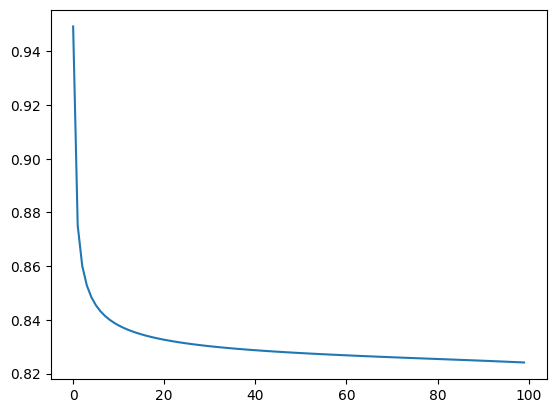

In [27]:
bow_rnn_predictions = []
original_lables_rnn_bow = []

with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_bow_vector(review_dict, row['stemmed_tokens'])
        probs = rnn_bow_model(bow_vec)
        bow_rnn_predictions.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
        original_lables_rnn_bow.append(make_target(Y_test['sentiment'][index]).cpu().numpy()[0])

print(classification_report(original_lables_rnn_bow,bow_rnn_predictions))
rnn_loss_df = pd.read_csv(rnn_loss_file_name)
print(len(rnn_loss_df))
print(rnn_loss_df.columns)
rnn_plt_500_padding_100_epochs = rnn_loss_df[' loss'].plot()
fig = rnn_plt_500_padding_100_epochs.get_figure()
fig.savefig("rnn_bow_loss_500_padding_100_epochs_less_lr.jpg")


In [17]:
# Open the file for writing loss
LSTM_loss_file_name = 'LSTM_bow_class_big_loss_500_epoch_100_less_lr.csv'
f2= open(LSTM_loss_file_name,'w')
f2.write('iter, loss')
f2.write('\n')
losses = []
iter = 0
# Start training
for epoch in range(num_epochs):
    if (epoch+1) % 25 == 0:
        print("Epoch completed: " + str(epoch+1))
    train_loss = 0
    for index, row in X_train.iterrows():
        # Clearing the accumulated gradients
        optimizer.zero_grad()

        # TODO: Make the bag of words vector for stemmed tokens
        bow_vec = make_bow_vector(review_dict, row['stemmed_tokens'])

        # TODO: Forward pass to get output
        probs = LSTM_bow_model(bow_vec)

        # Get the target label
        target = make_target(Y_train['sentiment'][index])

        # TODO: Calculate Loss: softmax --> cross entropy loss
        loss = loss_function(probs, target)

        # Accumulating the loss over time
        train_loss += loss.item()

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
    f2.write(str((epoch+1)) + "," + str(train_loss / len(X_train)))
    f2.write('\n')
    train_loss = 0

f2.close()

Epoch completed: 25
Epoch completed: 50
Epoch completed: 75
Epoch completed: 100


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.72      1.00      0.84       108
           1       0.00      0.00      0.00        21
           2       0.00      0.00      0.00        21

    accuracy                           0.72       150
   macro avg       0.24      0.33      0.28       150
weighted avg       0.52      0.72      0.60       150

100
Index(['iter', ' loss'], dtype='object')


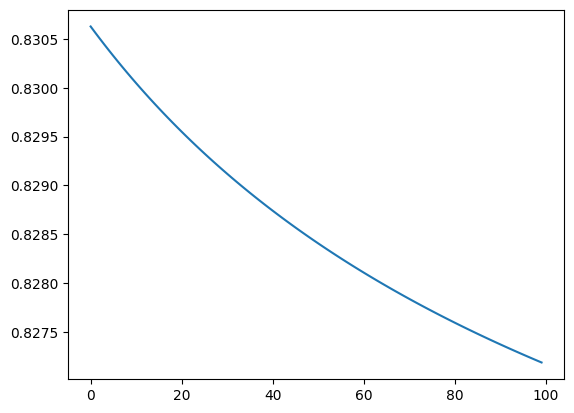

In [18]:
bow_LSTM_predictions = []
original_lables_LSTM_bow = []

with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_bow_vector(review_dict, row['stemmed_tokens'])
        probs = LSTM_bow_model(bow_vec)
        bow_LSTM_predictions.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
        original_lables_LSTM_bow.append(make_target(Y_test['sentiment'][index]).cpu().numpy()[0])

print(classification_report(original_lables_LSTM_bow,bow_LSTM_predictions))
LSTM_loss_df = pd.read_csv(LSTM_loss_file_name)
print(len(LSTM_loss_df))
print(LSTM_loss_df.columns)
LSTM_plt_500_padding_100_epochs = LSTM_loss_df[' loss'].plot()
fig = LSTM_plt_500_padding_100_epochs.get_figure()
fig.savefig("LSTM_bow_loss_500_padding_100_epochs_less_lr.jpg")
